In [1]:
%load_ext blackcellmagic

# Project 1  
## The Moonshadow Elves  
* Hongmei Zeng  
* Noah Stettler  
* Patrick Harrington  
* Yacub Bholat  
  
Due: 18 January 2020  

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import requests
import api_keys

# globally matplotlib formatting
matplotlib.rcParams["figure.figsize"] = [20, 10]
matplotlib.rcParams.update({"font.size": 14})

## Authenticate Slipstream Home Junction API using Key
* Get authentication token
* Create header with token

In [3]:
# documentation: https://slipstream.homejunction.com/#/ws/?id=authentication
path = "https://slipstream.homejunction.com/ws/api/authenticate"
payload = {"license": api_keys.slipstream_api_key}
r = requests.get(path, params=payload)

# extract slipstream authentication token and create headers dict
# documentation: https://slipstream.homejunction.com/#/ws/?id=tokens
token = r.json()["result"]["token"]
headers = {"HJI-Slipstream-Token": token}
r.status_code

200

## Get all Austin, TX zip codes from Slipstream Home Junction API

In [4]:
# get all zip codes in austin, tx and associated zip code attributes
# documentation: https://slipstream.homejunction.com/#/ws/areas/zipcodes?id=search
path = "https://slipstream.homejunction.com/ws/areas/zipcodes/search"
payload = {
    "county": "travis",
    "state": "tx",
    "details": "true",
    "geometry": "true",
    "pageSize": "1000",
}
r = requests.get(path, params=payload, headers=headers)
r.status_code

200

In [5]:
r.json()

{'success': True,
 'result': {'total': 50,
  'zipcodes': [{'geoType': 'area/zipcode',
    'id': 'd4bb86ba102ac1c968962df78bc2a697',
    'name': '78774',
    'areaType': 'zipcode',
    'type': 'zipcode',
    'label': '78774, Austin, TX',
    'place': {'name': 'Austin'},
    'county': {'id': '1ac3868c36cd18fae9b5b3300e6f5383', 'name': 'Travis'},
    'state': {'id': '37d24c232b3fe1cf979241517be67a54',
     'name': 'Texas',
     'abbreviation': 'TX'},
    'zipType': 'Unique',
    'centroid': {'latitude': 30.278134, 'longitude': -97.738329},
    'internalPoint': {'latitude': 30.2781311721144,
     'longitude': -97.738329950132},
    'population': {'current': 13,
     '1990': 13,
     '2000': 15,
     '2010': 12,
     'density': 2252.6},
    'gender': {'male': 57.71, 'female': 42.29},
    'age': {'median': 32,
     'male': 34.3,
     'female': 27.8,
     'white': 33.8,
     'black': 42.9,
     'asian': 23.1,
     'hispanic': 25.8,
     'Y0_5': 1.71,
     'Y6_11': 1.99,
     'Y12_17': 1.42,
 

### Create series with Austin, TX zip codes

In [6]:
# n = {zipcode['name'] : zipcode['geometry']['coordinates'] for zipcode in r.json()['result']['zipcodes']} # zip codes and lat/long data
zip_list = [
    int(zipcode["name"]) for zipcode in r.json()["result"]["zipcodes"]
]  # only zip codes
zip_list = pd.Series(zip_list)
zip_list.name = "ZipCode"
zip_list

0     78774
1     78755
2     78758
3     78669
4     78744
5     78736
6     78738
7     78719
8     78726
9     78653
10    78710
11    78733
12    78753
13    78722
14    78742
15    78725
16    78617
17    78732
18    78748
19    78705
20    78703
21    78756
22    78730
23    78728
24    78754
25    78735
26    78741
27    78731
28    78723
29    78724
30    78712
31    78645
32    78701
33    78751
34    78660
35    78734
36    78747
37    78727
38    78759
39    78750
40    78752
41    78745
42    78652
43    78704
44    78721
45    78739
46    78749
47    78746
48    78702
49    78757
Name: ZipCode, dtype: int64

## Create Austin, TX home sale dataframe
* Import Zillow bulk data from CSV
* Merge with zip code series

In [7]:
zillow_sale_price_csv = os.path.join("Data", "Sale_Prices_Zip.csv")
zillow_df = (
    pd.read_csv(zillow_sale_price_csv)
    .drop(columns=["RegionID", "StateName", "SizeRank"])
    .rename(columns={"RegionName": "ZipCode"})
)
zillow_df = pd.merge(zillow_df, zip_list, how="inner", on="ZipCode")
zillow_df = zillow_df.set_index("ZipCode").transpose()
zillow_df

ZipCode,78660,78704,78745,78748,78758,78753,78759,78744,78723,78749,...,78754,78653,78752,78747,78739,78645,78732,78669,78721,78725
2008-03,NaN,304400.0,168200.0,177600.0,132300.0,134800.0,267600.0,NaN,189000.0,228300.0,...,NaN,NaN,NaN,NaN,318200.0,NaN,NaN,NaN,NaN,NaN
2008-04,NaN,295100.0,164300.0,171000.0,131200.0,130600.0,274500.0,NaN,200000.0,226700.0,...,NaN,NaN,NaN,NaN,318500.0,NaN,NaN,NaN,NaN,NaN
2008-05,NaN,275700.0,163500.0,175600.0,129300.0,124300.0,266600.0,NaN,191000.0,230400.0,...,NaN,NaN,NaN,NaN,306800.0,NaN,NaN,NaN,NaN,NaN
2008-06,NaN,283300.0,165400.0,172900.0,134000.0,123600.0,262400.0,NaN,178400.0,228900.0,...,NaN,NaN,NaN,NaN,311300.0,NaN,NaN,NaN,NaN,NaN
2008-07,NaN,284400.0,169000.0,175300.0,138600.0,126100.0,267700.0,NaN,185500.0,231700.0,...,NaN,NaN,NaN,NaN,323300.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07,254000.0,552900.0,328300.0,300200.0,281400.0,247700.0,449100.0,233300.0,377100.0,387500.0,...,250400.0,203200.0,326400.0,260600.0,482400.0,290600.0,513900.0,467500.0,346800.0,212500.0
2019-08,258500.0,590200.0,341200.0,297700.0,283900.0,251600.0,474300.0,237900.0,408800.0,398700.0,...,252400.0,205700.0,298700.0,272200.0,488600.0,286400.0,506900.0,491600.0,332200.0,207000.0
2019-09,257000.0,565500.0,342000.0,297600.0,281600.0,258100.0,464200.0,243400.0,409500.0,395100.0,...,256600.0,207100.0,307000.0,274600.0,493100.0,319000.0,496200.0,486900.0,341400.0,204800.0
2019-10,261200.0,566900.0,347700.0,306500.0,311200.0,267700.0,467700.0,245700.0,414600.0,382300.0,...,257800.0,204600.0,326400.0,282100.0,507700.0,319400.0,490600.0,452500.0,349400.0,204600.0


## Evaluate home sale data statistics

* General home sale statistics by zip code

In [8]:
zillow_df_statistics = zillow_df.describe()
zillow_df_statistics

ZipCode,78660,78704,78745,78748,78758,78753,78759,78744,78723,78749,...,78754,78653,78752,78747,78739,78645,78732,78669,78721,78725
count,113.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,67.000000,140.000000,140.000000,...,91.000000,94.000000,26.000000,67.000000,140.000000,80.000000,116.000000,82.000000,66.000000,55.000000
mean,195971.681416,392964.285714,226515.714286,220993.571429,175219.285714,170328.571429,345924.285714,195783.582090,255613.571429,290625.714286,...,207649.450549,161574.468085,309076.923077,237079.104478,393417.857143,232190.000000,430452.586207,379946.341463,276253.030303,175783.636364
std,40115.610760,92211.350970,59201.428224,47256.415515,55647.881790,48558.761089,63269.593174,30759.751334,80553.083807,57492.219519,...,35396.733602,35633.236075,34491.556157,23716.127599,65258.216791,33004.129393,56442.243602,60258.683499,44748.363854,19843.384602
min,137500.000000,238600.000000,155500.000000,162500.000000,103000.000000,108100.000000,250200.000000,139900.000000,144200.000000,211200.000000,...,148600.000000,88700.000000,236600.000000,188200.000000,302700.000000,175600.000000,298900.000000,255600.000000,176800.000000,140400.000000
25%,154400.000000,304550.000000,172300.000000,176325.000000,127475.000000,127025.000000,289775.000000,173700.000000,182400.000000,232900.000000,...,175750.000000,135800.000000,292200.000000,220750.000000,330425.000000,208250.000000,387225.000000,332900.000000,253725.000000,161450.000000
50%,196700.000000,383400.000000,209600.000000,208050.000000,154400.000000,148650.000000,332350.000000,190700.000000,238500.000000,285500.000000,...,208200.000000,172250.000000,306700.000000,234000.000000,385900.000000,228800.000000,428000.000000,373650.000000,281950.000000,174900.000000
75%,236200.000000,473275.000000,276175.000000,268100.000000,219475.000000,219475.000000,402650.000000,224200.000000,326100.000000,346200.000000,...,239900.000000,187325.000000,326400.000000,256800.000000,454100.000000,252800.000000,485350.000000,427700.000000,310325.000000,192450.000000
max,261200.000000,590200.000000,347700.000000,306500.000000,311200.000000,267700.000000,474300.000000,249500.000000,414600.000000,398700.000000,...,257800.000000,217900.000000,384000.000000,282100.000000,507700.000000,319400.000000,528500.000000,503000.000000,349400.000000,212500.000000


* Take the first difference of the home sale prices by zip code
* Calculate mean and standard deviation of first difference df to determine volatility in home sales

In [9]:
zillow_df_diff = zillow_df.diff()

zillow_df_diff_statistics = pd.DataFrame(
    {"mean": zillow_df_diff.mean(), "stdev": zillow_df_diff.std()}
)
zillow_df_diff_statistics

,mean,stdev
ZipCode,,
78660,977.678571,3138.620510
78704,1888.489209,16468.785050
78745,1291.366906,4293.262028
78748,927.338129,4001.481714
78758,1287.050360,8350.161281
78753,956.115108,5953.809097
78759,1439.568345,15489.354075
78744,1540.909091,5410.018549
78723,1623.021583,9172.211629


## Plot Home Sale Data
* Define a function

In [10]:
def plot_home_sale_data(df):
    df.plot()
    plt.legend(
        loc="upper left",
        bbox_to_anchor=(0, 1.0),
        ncol=int(np.ceil(len(df.columns) / 6)),
        fancybox=False,
        shadow=True,
    )
    plt.title("Property Sale Price vs. Time by Zip Code")
    plt.xlabel("Sale Date")
    plt.ylabel("Sale Price ($)")
    plt.show()

* Plot data across all zip codes

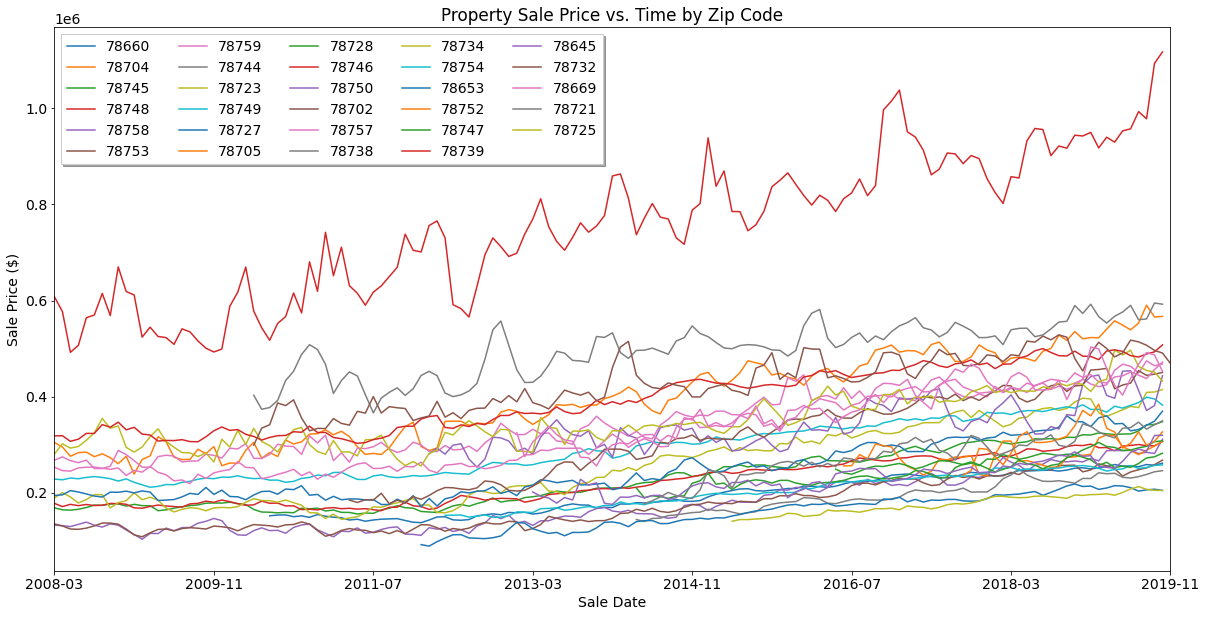

In [11]:
plot_home_sale_data(zillow_df)

* Plot data for select zip codes

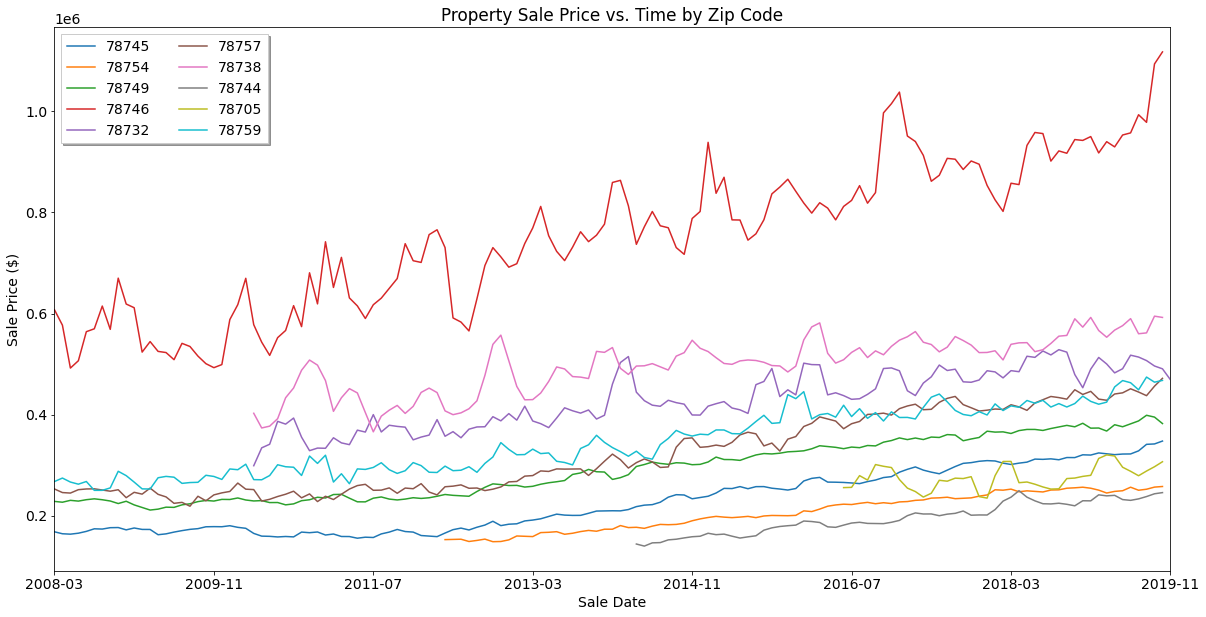

In [12]:
zillow_df_subset = zillow_df[
    [78745, 78754, 78749, 78746, 78732, 78757, 78738, 78744, 78705, 78759]
]
plot_home_sale_data(zillow_df_subset)

## Create a series with home sale data by year across all of Austin
* First create a dataframe of home sale data by zip code and by year
* Then create a series of home sale data for Austin by taking the median home sale value across all zip codes

In [13]:
zillow_df_annual = zillow_df[[i[-2:] == "11" for i in zillow_df.index]]
zillow_df_annual.index = [i[:4] for i in zillow_df_annual.index]

zillow_series_annual_austin = zillow_df_annual.median(axis=1)
zillow_series_annual_austin

2008    224100.0
2009    229000.0
2010    237350.0
2011    232900.0
2012    236650.0
2013    263900.0
2014    273000.0
2015    277600.0
2016    297250.0
2017    308900.0
2018    338900.0
2019    469000.0
dtype: float64

## Import Austin Population Data

# PATRICK CODE

## Import Austin Employment Data

In [33]:
path = os.path.join("Data", "SeriesReport-20200112162716_5da8f4.csv")
df = pd.read_csv(path)
df.head(20)

In [34]:
df["Unnamed: 1"][2]

In [35]:
cleaned_df = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
cleaned_df.head()

In [36]:
names = {
    "Local Area Unemployment Statistics": "Year",
    "Unnamed: 1": "Month",
    "Unnamed: 2": "Labor Force",
    "Unnamed: 3": "Employment",
    "Unnamed: 4": "Unemployment",
    "Unnamed: 5": "Unemployment Rate %",
}
cleaned_df = cleaned_df.rename(columns=names)
cleaned_df = cleaned_df.reset_index(drop=True)
cleaned_df.tail(10)

In [37]:
cleaned_df["Labor Force"] = cleaned_df["Labor Force"].astype("int")
cleaned_df["Employment"] = cleaned_df["Employment"].astype("int")
cleaned_df["Unemployment"] = cleaned_df["Unemployment"].astype("int")
cleaned_df["Unemployment Rate %"] = cleaned_df["Unemployment Rate %"].astype("float")

In [38]:
cleaned_df["Employment Rate %"] = (
    (cleaned_df["Employment"] / cleaned_df["Labor Force"]) * 100
).round(1)
cleaned_df.head(10)

In [39]:
new_df = cleaned_df[
    [
        "Year",
        "Month",
        "Labor Force",
        "Employment",
        "Employment Rate %",
        "Unemployment",
        "Unemployment Rate %",
    ]
]
new_df.head(20)

In [40]:
# Delete the Data of the year 2019
new_df = new_df[new_df.Year != "2019"]
new_df

In [41]:
yearly_df = new_df[new_df.Month == "Annual"].drop(columns=["Month"])
yearly_df.set_index(["Year"], inplace=True)
yearly_df

In [42]:
x = yearly_df.index
y = yearly_df["Employment"]
plt.plot(x, y, color="blue", marker="o", linewidth=2, markersize=8)

plt.xlabel("Year")
plt.ylabel("Employment Amount")
plt.title("Employment Amount of Austin City(2010-2018)", fontsize=12)
plt.grid(axis="both", linestyle="-")
# plt.savefig('Fig1 Employment Amount.png')
plt.show()

In [43]:
x = yearly_df.index
y = yearly_df["Employment Rate %"]
plt.plot(x, y, color="green", marker="o", linewidth=2, markersize=8)

plt.xlabel("Year")
plt.ylabel("Employment Rate (%)")
plt.title("Employment Rate of Austin City(2010-2018)", fontsize=12)
plt.ylim(80, max(y) + 10)
plt.grid(axis="both", linestyle="-")
# plt.savefig('Fig2 Employment Rate.png')
plt.show()

In [44]:
monthly_df = new_df[new_df.Month != "Annual"]
monthly_df

In [45]:
monthly_employment_df = pd.pivot_table(
    monthly_df, index="Year", columns="Month", values="Employment"
)
monthly_employment_df = monthly_employment_df[
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
]
monthly_employment_df

In [46]:
colors = [
    "red",
    "blue",
    "green",
    "orange",
    "cyan",
    "magenta",
    "yellow",
    "black",
    "grey",
    "brown",
    "silver",
    "purple",
]
markers = ["^", "o", "s", "*", "8", "p", "X", "D", "x", "h", "+", "|"]

x = monthly_employment_df.index
for column, i in zip(
    monthly_employment_df.columns, range(len(monthly_employment_df.columns))
):
    y = monthly_employment_df[column]
    plt.errorbar(
        x,
        y,
        yerr=3,
        elinewidth=0.8,
        color=colors[i],
        marker=markers[i],
        linestyle=":",
        linewidth=1,
        errorevery=1,
        label=column,
    )

plt.xlabel("Year")
plt.ylabel("Employment")
plt.title("Monthly Employment Amount(2010-2018)", fontsize=12)
plt.legend(loc="lower right")
plt.ylim(400000, max(y) + 10000)
plt.grid(axis="y", linestyle="-")
plt.figure(figsize=(15, 9))
# plt.savefig('Fig3 Monthly Employment Amount.png')
plt.show()

In [47]:
monthly_employment_rate_df = pd.pivot_table(
    monthly_df, index="Year", columns="Month", values="Employment Rate %"
)
monthly_employment_rate_df = monthly_employment_rate_df[
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
]
monthly_employment_rate_df

In [48]:
colors = [
    "red",
    "blue",
    "green",
    "orange",
    "cyan",
    "magenta",
    "yellow",
    "black",
    "grey",
    "brown",
    "silver",
    "purple",
]
markers = ["^", "o", "s", "*", "8", "p", "X", "D", "x", "h", "+", ","]

x = monthly_employment_rate_df.index
for column, i in zip(
    monthly_employment_rate_df.columns, range(len(monthly_employment_rate_df.columns))
):
    y = monthly_employment_rate_df[column]
    plt.errorbar(
        x,
        y,
        yerr=0.5,
        elinewidth=0.8,
        color=colors[i],
        marker=markers[i],
        linestyle=":",
        linewidth=1,
        errorevery=1,
        label=column,
    )

plt.xlabel("Year")
plt.ylabel("Employment Rate %")
plt.title("Monthly Employment Rate(2010-2018)", fontsize=12)
plt.legend(loc="lower right")
plt.ylim(90, max(y) + 2.5)
plt.grid(axis="y", linestyle="-")
plt.figure(figsize=(15, 9))
# plt.savefig('Fig4 Monthly Employment Rate.png')
plt.show()

In [49]:
monthly_df

In [50]:
monthly_df["Year-Month"] = monthly_df["Year"] + "-" + monthly_df["Month"]
monthly_df

In [51]:
x = monthly_df["Year-Month"]
y = monthly_df["Employment"]
plt.plot(x, y, color="red", marker="o", linewidth=2, markersize=8)

plt.xlabel("Year-Month")
plt.ylabel("Employment Amount")
plt.title("Employment Statistics of Austin City(2010-2018)", fontsize=12)
plt.grid(axis="both", linestyle="-")
plt.figure(figsize=(15, 9))
# plt.savefig('Fig5 Employment Statistics.png')
plt.show()

## Import Austin Demographic Data

# NOAH CODE

## Merge Housing, Population, Employment, and Demographic Data on Year

## Plot Population vs. Housing Data

## Plot Population vs. Employment Data

## Export Housing, Population, Labor/Job, and Demographics Data into Separate Table in One SQL Database